In [112]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score


#Вчитување на податоците

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
df = pd.read_csv("/content/drive/My Drive/with_genres.csv")
df.shape

(1991, 23)

In [115]:
target = df['target']
df.drop(['Unnamed: 0.1','Unnamed: 0','title','artist', 'uri', 'type','target'], axis=1, inplace=True)
df.head(10)

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,popularity,year,genre
0,0.425,0.1000,135.128,0.3750,0.328,0.130000,4,0.701,7,194088,-10.965,0.5620,1,89,2019,22
1,0.125,0.2650,111.554,0.2390,0.751,0.002070,4,0.521,9,243725,-17.832,0.0528,1,78,2019,22
2,0.533,0.1390,150.455,0.1860,0.462,0.219000,4,0.678,4,180953,-10.485,0.3230,1,81,2019,22
3,0.444,0.1770,185.044,0.3720,0.283,0.143000,4,0.726,8,168840,-8.922,0.5690,0,80,2019,22
4,0.351,0.7520,118.028,0.2410,0.390,0.000009,4,0.853,7,221543,-10.198,0.2820,1,81,2019,22
5,0.111,0.0897,82.642,0.0972,0.978,0.000040,4,0.367,4,196077,-14.084,0.1980,1,86,2019,22
6,0.235,0.1070,62.446,0.3150,0.698,0.006040,4,0.735,3,173202,-13.239,0.4620,1,75,2019,22
7,0.305,0.1050,100.029,0.3540,0.350,0.000169,4,0.939,8,179889,-10.952,0.5630,0,78,2019,22
8,0.389,0.1060,120.046,0.3320,0.740,0.162000,4,0.905,8,193143,-14.505,0.1960,1,81,2019,22
9,0.423,0.0896,120.020,0.0585,0.724,0.469000,4,0.855,5,156371,-15.044,0.5720,0,78,2019,22


In [116]:
cols = ['genre']  + [col for col in df if col != 'genre']
df = df[cols]

**PCA - Principal Component Analysis**

Може да биде особено корисно да се поедностават нашите модели и да се користат што помалку атрибути за да се постигне најдобриот резултат.
За да ја намалиме комплексноста на моделот, може да се обидеме да ја намалиме димензионалноста, односно со помош на PCA да ги најдеме и искористеме само атрибутите кои придонесуваат најмногу кон вараијансата меѓу класите.

Меѓутоа, бидејќи PCA ја користи апсолутната варијанса на одреден атрибут за да ги ротира податоците, атрибутите со поширок опсег на вредности ќе го пристраснат алгоритмот во однос на другите атрибути. За да се избегне ова, прво мора да ги нормализираме нашите податоци. Постојат неколку методи за да се направи ова, но вообичаен начин е преку стандардизација, така што сите карактеристики имаат просек = 0 и стандардна девијација = 1.

In [117]:
#Normalizing all numerical features:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(df)

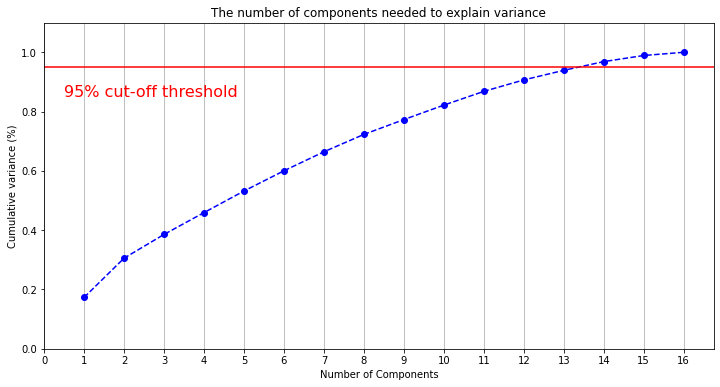

In [118]:
pca = PCA().fit(data_rescaled)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 17, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 17, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Од графикот погоре може да забележиме дека оптимaлниот број на атрибути е 13  ако сакаме да имаме приближно 95% варијанса.

In [119]:
# Fit your dataset to the optimal pca
pca = PCA(n_components=13)
pca.fit(data_rescaled)
X_pca = pca.transform(data_rescaled)

In [120]:
df = pd.DataFrame(data=X_pca)
df['target'] = target
df.shape

(1991, 14)

#Делење на податочното множество на тренирачко, валидациско и тестирачко 

Делење на податочното множество на тренирачко, валидациско и тестирачко множество, 
    така што првите 70% од секоја од класите  се доделени во тренирачкото множество. 
    Следните 10% од секоја од класите влегуваат во валидациско множество, 
    а последните 20% од секоја од класите се дел од тестирачкото множество.
    На крај се прави shuffle на множествата (заедно со соодветните лабели).

In [121]:
tmp = df.values.tolist().copy()
dataset =  [[row[i] if i != len(row)-1   else int(row[i]) for i in range(len(row))] for row in tmp]
print(tmp)
print(dataset)

bad_classes = [x for x in dataset if x[-1] == 0]
good_classes = [x for x in dataset if x[-1] == 1]

train_set =  bad_classes[:int(len(bad_classes) * 0.7)] + good_classes[:int(len(good_classes) * 0.7)]
val_set = bad_classes[int(len(bad_classes) * 0.7):int(len(bad_classes) * 0.8)] + good_classes[int(len(good_classes) * 0.7):int(len(good_classes) * 0.8)]
test_set =  bad_classes[int(len(bad_classes) * 0.8):] + good_classes[int(len(good_classes) * 0.8):]

train_x = [x[:-1] for x in train_set]
train_y = [x[-1] for x in train_set]
val_x = [x[:-1] for x in val_set]
val_y = [x[-1] for x in val_set]
test_x = [x[:-1] for x in test_set]
test_y = [x[-1] for x in test_set]


[[1.128391401558761, 2.6511093888869857, -2.099596210774058, -0.7934473023289891, -1.4686232579474643, 0.7588468510444207, -0.9650539561792165, 0.3716813962674325, 0.581210626384042, 0.36468104154321557, 0.7165073395424291, -0.6965300568144354, 0.8688324328127016, 1.0], [4.506567290236003, 3.41167099393995, -0.9134021170181493, 0.1743771658251396, -0.7333673087413336, 1.0220785638971688, 0.49719478272217116, 0.04827221261779565, 0.9219709543934703, -1.2571450655997642, 0.45549014339581917, -0.5932525971506215, -0.040924791096332985, 1.0], [1.6090368128263774, 1.9038519978922757, -1.5316713230539154, -0.9236080695123714, -0.4909272995903087, 0.5131225504000699, -0.8576461052454515, -0.4626977485287901, 0.167833105258277, 0.6613615385772064, -0.6192361778960334, -0.6222773077263596, 0.43816738815650486, 1.0], [0.2513060425213178, 2.458527184780848, -1.549281238712525, 0.22014248364168715, -2.032436709019791, 1.9768275199389957, -1.873683588476728, -0.4353054575565214, -0.837041021363264,

In [122]:
import collections
X_train = np.array(train_x)
y_train = np.array(train_y)
X_val = np.array(val_x)
y_val = np.array(val_y)
X_test = np.array(test_x)
y_test = np.array(test_y)

from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train,random_state=0)
X_val, y_val = shuffle(X_val, y_val,random_state=0)
X_test, y_test = shuffle(X_test, y_test,random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(collections.Counter(y_train))
print(collections.Counter(y_val))
print(collections.Counter(y_test))

(1392, 13) (200, 13) (399, 13)
(1392,) (200,) (399,)
Counter({1: 702, 0: 690})
Counter({1: 101, 0: 99})
Counter({1: 201, 0: 198})


In [123]:
#80% train, 20% test
xtrain = np.concatenate((X_train,X_val)) 
ytrain = np.concatenate((y_train,y_val))  

Проба на некои од моделите со користење на податочното множество со редуцирана димензионалност со помош на PCA.

#Наивен Баесов, Дрво на одлука и Рандом Форест

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier()
nbc = GaussianNB()
rfc = RandomForestClassifier()

dtc.fit(xtrain, ytrain)
nbc.fit(xtrain, ytrain)
rfc.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
from sklearn.metrics import classification_report

test_tree_predict = dtc.predict(X_test)
test_naive_predict = nbc.predict(X_test)
test_random_forest_predict = rfc.predict(X_test)

print('Decision Tree score on test:\n', classification_report( y_test,test_tree_predict))
print('Naive Bayes score on test:\n', classification_report( y_test,test_naive_predict))
print('Random Forest score on test:\n', classification_report( y_test,test_random_forest_predict))

Decision Tree score on test:
               precision    recall  f1-score   support

           0       0.45      0.57      0.50       198
           1       0.42      0.30      0.35       201

    accuracy                           0.44       399
   macro avg       0.43      0.44      0.43       399
weighted avg       0.43      0.44      0.43       399

Naive Bayes score on test:
               precision    recall  f1-score   support

           0       0.54      0.79      0.64       198
           1       0.62      0.34      0.44       201

    accuracy                           0.56       399
   macro avg       0.58      0.57      0.54       399
weighted avg       0.58      0.56      0.54       399

Random Forest score on test:
               precision    recall  f1-score   support

           0       0.52      0.70      0.60       198
           1       0.56      0.38      0.45       201

    accuracy                           0.54       399
   macro avg       0.54      0.54      0

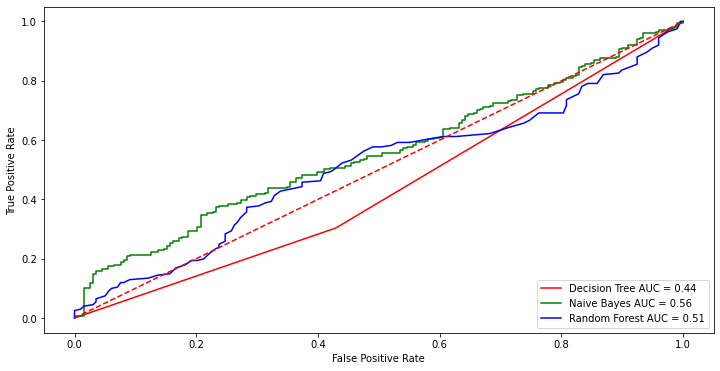

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

actual = y_test
decision_tree_prob = [p[1] for p in dtc.predict_proba(X_test)]
naive_bayes_prob = [p[1] for p in nbc.predict_proba(X_test)]
random_forest_prob = [p[1] for p in rfc.predict_proba(X_test)]

dt_false_pos, dt_true_pos, _ = roc_curve(actual, decision_tree_prob)
dt_auc = auc(dt_false_pos, dt_true_pos)

nb_false_pos, nb_true_pos, _ = roc_curve(actual, naive_bayes_prob)
nb_auc = auc(nb_false_pos, nb_true_pos)

rf_false_pos, rf_true_pos, _ = roc_curve(actual, random_forest_prob)
rf_auc = auc(rf_false_pos, rf_true_pos)

# plot
plt.plot(dt_false_pos, dt_true_pos, 'r', label='Decision Tree AUC = %0.2f'% dt_auc)
plt.plot(nb_false_pos, nb_true_pos, 'g', label='Naive Bayes AUC = %0.2f'% nb_auc)
plt.plot(rf_false_pos, rf_true_pos, 'b', label='Random Forest AUC = %0.2f'% rf_auc)

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Како што можеме да забележиме се добиваат прилично лоши резултати. 
PCA не ги зема во предвид класите па тоа би значело дека може да се отфрли атрибут кој многу придоесува за прецизна разделба на податоците во класи и понекогаш примената на PCA може да доведе до полоши резултати во проблемите со надгледувано учење т.е класификацијa како што е во нашиот случај.